# Fetching the dataset from Meteostat API and preprocessing it

This Jupyter notebook fetches the weather data csv files from Meteostat API and preprocesses them for further analysis. The dataset includes daily weather data for various locations.


## Importing Libraries

In [1]:
import pandas as pd
from meteostat import Point, Hourly, Daily, Stations
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np

## Limit the weather stations to Europe

In [2]:
stations = Stations()
stations = stations.bounds((70, -10), (20, 30))
print('Stations in Europe:', stations.count())

Stations in Europe: 3834


In [3]:
stations_data = stations.fetch()
stations_data['nan_count'] = stations_data.isna().sum(axis=1)


stations_data = stations_data.sort_values(by='nan_count')  # Sort by NaN count
stations_data = stations_data.groupby('region').head(3)  # Limit to 4 per region

# Drop the temporary 'nan_count' column
stations_data = stations_data.drop(columns=['nan_count'])
stations_data = stations_data[stations_data['hourly_start'].notna() & stations_data['hourly_end'].notna() & stations_data['icao'].notna()]
stations_data

,name,country,region,wmo,icao,latitude,longitude,elevation,timezone,hourly_start,hourly_end,daily_start,daily_end,monthly_start,monthly_end
id,,,,,,,,,,,,,,,
06407,Oostende Airport,BE,VWV,06407,EBOS,51.2000,2.8667,4.0,Europe/Brussels,1936-01-03,2025-05-26,1973-01-10,2022-04-25,2005-01-01,2022-01-01
07130,Rennes,FR,E,07130,LFRN,48.0667,-1.7333,37.0,Europe/Paris,1931-01-05,2025-05-26,1944-11-01,2025-03-31,1944-01-01,2022-01-01
07139,Alencon,FR,P,07139,LFOF,48.4500,0.1167,144.0,Europe/Paris,1973-01-01,2025-05-26,1973-01-01,2025-05-23,1973-01-01,2022-01-01
07140,Chateaudun,FR,F,07140,LFOC,48.0500,1.3833,134.0,Europe/Paris,1973-01-01,2025-01-13,1999-04-11,2022-03-28,2008-01-01,2021-01-01
07143,Chartres,FR,F,07143,LFOR,48.4667,1.5167,155.0,Europe/Paris,1936-06-17,2025-01-13,1999-03-24,2022-03-28,2005-01-01,2021-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GMMT0,Casablanca / Tit Mellil,MA,CBL,<NA>,GMMT,33.5949,-7.4645,96.0,Africa/Casablanca,2011-11-12,2021-07-06,NaT,NaT,NaT,NaT
HEAL0,El Alamein / A? ?ab‘ah,EG,MT,<NA>,HEAL,30.9245,28.4614,44.0,Africa/Cairo,2020-04-19,2025-05-25,NaT,NaT,NaT,NaT
HEOW0,Shark El Oweinat,EG,WAD,<NA>,HEOW,22.5857,28.7166,262.0,Africa/Cairo,2001-07-13,2023-01-09,NaT,NaT,NaT,NaT


## Get overview of weather stations Geolocations

In [4]:
import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx

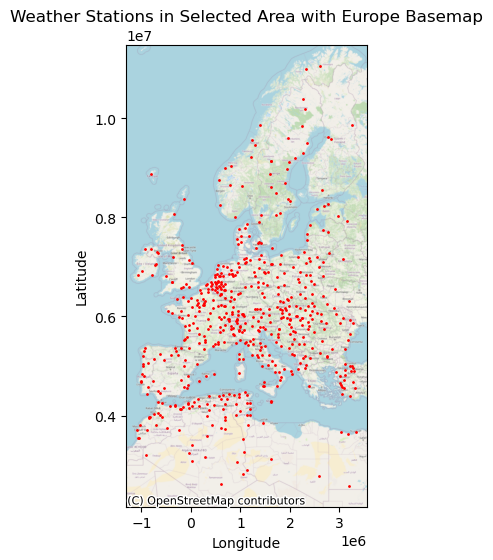

In [5]:
# Convert the stations data to a GeoDataFrame

geometry = [Point(xy) for xy in zip(stations_data['longitude'], stations_data['latitude'])]
geo_df = gpd.GeoDataFrame(stations_data, geometry=geometry, crs="EPSG:4326")

# Reproject to Web Mercator for compatibility with contextily
geo_df = geo_df.to_crs(epsg=3857)

# Plot the stations on a map with a basemap
ax = geo_df.plot(marker='o', color='red', markersize=1, figsize=(10, 6))
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik, zoom=5)
plt.title("Weather Stations in Selected Area with Europe Basemap")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

In [6]:
from tqdm import tqdm
import os
import warnings
warnings.filterwarnings("ignore")
# Iterate through each station and fetch its climate data
output_folder = 'data'
for index, station in tqdm(stations_data.iterrows(), total=stations_data.shape[0]):
    station_id = index
    # Create the Point object for the station
    data_end = datetime.strptime(str(station['hourly_end']), '%Y-%m-%d %H:%M:%S')
    # Calculate 20 years ago from data_end
    twenty_years_ago = data_end - timedelta(days=365*20)
    # Use the later of hourly_start or 20 years ago
    data_start = max(datetime.strptime(str(station['hourly_start']), '%Y-%m-%d %H:%M:%S'), twenty_years_ago)
    data = Hourly(station_id, start=data_start, end=data_end)
    data.threads = 2
    data = data.fetch()
    # Save the data to a CSV file in the 'extr' folder
    output_file = os.path.join(output_folder, f"{station_id}_hourly.csv")
    data.to_csv(output_file)

print("All hourly data has been downloaded.")

  0%|          | 0/562 [00:00<?, ?it/s]

100%|██████████| 562/562 [42:56<00:00,  4.59s/it]

All hourly data has been downloaded.
